<a href="https://colab.research.google.com/github/andreusjh99/Learning-Tensorflow2.0/blob/master/R1_Simple_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


This series goes through some of the most common ML algorithms to see how TensorFlow 2.0 works.

1. Regression
2. Classification
3. Clustering
4. Hidden Markov Model 



# Core Learning Algorithms 1 - Regression


## **Linear Regression**

`y = mx + c`

To illustrate, we are going to use a fake dataset.

## Workflow

1. Import stuff
2. Load your dataset using pandas
3. Preprocess the data
4. Create model
5. Train model
6. Evaluate model
7. Visualise results (if possible)

## Setup and imports



In [1]:
!pip install -q sklearn

In [2]:
%tensorflow_version 2.x  # this line is not required unless you are in a notebook

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `2.x  # this line is not required unless you are in a notebook`. This will be interpreted as: `2.x`.


TensorFlow 2.x selected.


In [3]:
!python --version

Python 3.6.9


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from sklearn.model_selection import train_test_split

from IPython.display import clear_output
from six.moves import urllib

import tensorflow.compat.v2.feature_column as fc

In [5]:
print(tf.__version__)

2.2.0


## Creating dataset

Note: this part is just to create data for our regression problem.

The data we are creating is

`y = 0.5x + 5 + n` where `n` is gaussian noise.

In [6]:
# one million data points
x_data = np.linspace(0.0, 10.0, 1000000)

In [7]:
np.random.seed(1000)
noise = np.random.randn(len(x_data))

In [8]:
# creating our labels
m, b = 0.5, 5
y_true = m*x_data + b + noise

In [9]:
# creating a dataframe
my_data = pd.concat([pd.DataFrame(data=x_data, columns=["X Data"]),
                     pd.DataFrame(data=y_true, columns=["Y"])], axis = 1)

In [10]:
my_data.head()

,X Data,Y
0,0.00000,4.195542
1,0.00001,5.320937
2,0.00002,4.974527
3,0.00003,5.644339
4,0.00004,4.699223


## Visualise data

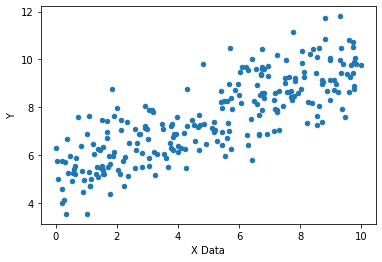

In [11]:
my_data.sample(n = 250).plot(kind='scatter', x='X Data', y="Y")

## Processing the CSV

We parse the values of the features and the labels from the Pandas dataframe. The steps:
1. Form the features array. (`X`)
2. Parse the label values. (`y`)
3. Split the `X` and `y` into training and testing datasets.
4. Convert all the arrays to `tf.Tensor` objects.

In [12]:
X = np.reshape(my_data['X Data'].values, [-1, 1])
y = my_data['Y'].values
# this gives numpy arrays of the X and y values.

# train-test split
train_feats, test_feats, train_labels, test_labels = train_test_split(
    X, y, test_size = 0.2)

# creating tf tensor objects
train_X = tf.constant(train_feats, dtype=tf.float32)
train_y = tf.constant(train_labels, dtype=tf.float32)
test_X = tf.constant(test_feats, dtype=tf.float32)
test_y = tf.constant(test_labels, dtype=tf.float32)

## Creating model

Steps:
1. Define loss fn and its deriv
2. Create the model function
3. Define hyperparameters
4. Define `tf.data.Dataset`

We use mean squared error in this problem.

$\Large MSE( y , \hat{y} ) = \frac{ \sum_{i=0}^{N} ( \hat{y}_i - y_i )^2 } { N }$

And its derivative wrt $\hat{y}$,

$\Large MSE'( y , \hat{y} ) = \frac{ 2 * \sum_{i=0}^{N} ( \hat{y}_i - y_i ) } { N }$

In [13]:
# tf.reduce_mean(x) calculate the mean of all values in the tensor x 
# and returns a reduced tensor.

def mean_squared_error(y, y_pred):
    return tf.reduce_mean(tf.square(y_pred - y))

def mean_squared_error_deriv(y, y_pred):
    return tf.reshape(tf.reduce_mean(2*(y_pred - y)), [1, 1])

We create the regression function from scratch here.

$\hat{y} = h(x) = W.X + \mathbf{b}$

In [14]:
def h(X, weights, bias):
    return tf.tensordot(X, weights, axes = 1) + bias

Hyperparameters:
1. epochs
2. batch_size: size of mini-batch used in mini-batch gradient descent
3. learning-rate

In [15]:
num_epochs = 150
num_samples = train_X.shape[0]
batch_size = 500
learning_rate = 0.01

print("No of samples in training dataset: ", num_samples)

No of samples in training dataset:  800000


We also create and shuffle our dataset.

In [16]:
dataset = tf.data.Dataset.from_tensor_slices((train_X, train_y))
dataset = dataset.shuffle(int(num_samples*1.5)) # shuffles data
dataset = dataset.repeat(num_epochs) # repeats the dataset by num_epochs times
dataset = dataset.batch(batch_size) # creates batches of size = batch_size
iterator = dataset.__iter__()

`dataset.shuffle(num)`
creates a buffer of size `num` and will the buffer up from the dataset, then elements will be selected randomly into a new dataset. 

As a space opens up in the buffer, then a new element will be added into the buffer from the dataset. Usually you would like to create a buffer of size bigger than your dataset for perfect shuffling.

## Training the model

We train the model for a given number of epochs. We perform optimization for every batch in our dataset.

$\Large loss = MSE( W.X + b ) $

To optimize the parameter $W$, the partial derivative of $MSE$ with respect to $W$ will be,

$\Large \frac{ \partial MSE }{ \partial W} = \frac{ \partial MSE }{ \partial h} * \frac{ \partial h }{ \partial W}$

Similarly for bias $b$ , 

$\Large \frac{ \partial MSE }{ \partial b} = \frac{ \partial MSE }{ \partial h} * 1 $

In [17]:
if len(train_X.shape) > 1:
    num_features = train_X.shape[1]
else:
    num_features = 1

print("No of features: ", num_features)

# note in this example weight is a tensor of shape [1, 1]

No of features:  1


In [18]:
# initialise params
tf.random.set_seed(1001)
weights = tf.random.normal((num_features, 1)) # creates a column vector (for dot product with X)
bias = 0

epochs_plot = list()
loss_plot = list()

# start training
for i in range(num_epochs):

    epoch_loss = list()
    for b in range(int(num_samples/batch_size)):
        x_batch, y_batch = iterator.get_next()

        output = h(x_batch, weights, bias)
        loss = mean_squared_error(y_batch, output).numpy() # .numpy() to get the value of the tensor object
        epoch_loss.append(loss)

        dJ_dH = mean_squared_error_deriv(y_batch, output) # a value
        dH_dW = x_batch # a matrix (batch_size, num_features)
        dJ_dW = tf.reduce_mean(dJ_dH * dH_dW)
        dJ_dB = tf.reduce_mean(dJ_dH)

        weights -= (learning_rate*dJ_dW)
        bias -= (learning_rate*dJ_dB)

    e_loss = np.array(epoch_loss).mean() # mean loss for one epoch
    epochs_plot.append(i + 1)
    loss_plot.append(e_loss)

    if i % 4 == 0:
        print("Epoch {}: Loss is {}".format(i+1, e_loss))

print("Final loss: ", e_loss)

Epoch 1: Loss is 21.9595947265625
Epoch 5: Loss is 19.999713897705078
Epoch 9: Loss is 18.286108016967773
Epoch 13: Loss is 16.83282470703125
Epoch 17: Loss is 15.518584251403809
Epoch 21: Loss is 14.386906623840332
Epoch 25: Loss is 13.368062973022461
Epoch 29: Loss is 12.5022611618042
Epoch 33: Loss is 11.739980697631836
Epoch 37: Loss is 11.074780464172363
Epoch 41: Loss is 10.483678817749023
Epoch 45: Loss is 9.959061622619629
Epoch 49: Loss is 9.472145080566406
Epoch 53: Loss is 9.035233497619629
Epoch 57: Loss is 8.659392356872559
Epoch 61: Loss is 8.322893142700195
Epoch 65: Loss is 8.017563819885254
Epoch 69: Loss is 7.739431381225586
Epoch 73: Loss is 7.499101638793945
Epoch 77: Loss is 7.27778434753418
Epoch 81: Loss is 7.0940446853637695
Epoch 85: Loss is 6.921716213226318
Epoch 89: Loss is 6.758502960205078
Epoch 93: Loss is 6.612450122833252
Epoch 97: Loss is 6.482539176940918
Epoch 101: Loss is 6.359775543212891
Epoch 105: Loss is 6.260962963104248
Epoch 109: Loss is 6.16

## Plot the loss curve

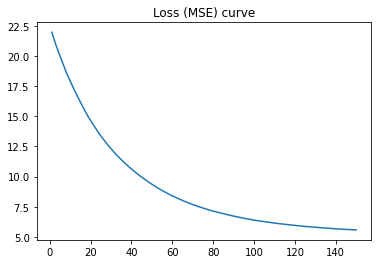

In [19]:
plt.plot( epochs_plot , loss_plot ) 
plt.title("Loss (MSE) curve")
plt.show()

## Evaluate the model

We evaluate our model's performance  by measuring the Mean Absolute Error on the test dataset.

In [24]:
output = h( test_X , weights , bias ) 
labels = test_y

accuracy_op = tf.metrics.MeanSquaredError() 
accuracy_op.update_state( labels , output )
print( 'Mean Squared Error = {}'.format( accuracy_op.result().numpy() ) )

Mean Squared Error = 1.0247975587844849


## Visualise result


In [25]:
print("weight: ", weights.numpy(), "bias: ", bias.numpy())

weight:  [[0.55045116]] bias:  4.767199


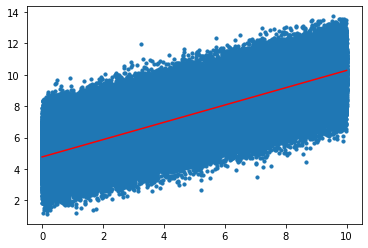

In [26]:
plt.scatter(X, y, s = 10)

# plot line
line_x = np.linspace(0.0, 10.0, 500)

line_y = weights.numpy()[0][0]*line_x + bias.numpy()
plt.plot(line_x, line_y, 'r')
